# Polarization state plots

This notebook produces a few figures representing gravitational waves (GWs) with different polarization states: linear, circular or elliptical.

Begin with some basic imports and settings.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patches import Circle, Wedge, Polygon
from utils.plots import EllipticalWedge
from utils.pols import *
import warnings

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

# suppress some annoying warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

plt.rcParams["text.usetex"] = "true"

## Simple circles

Illustrate the effect of $+$ and $\times$ polarizations on a freely-falling ring of particles.

In [3]:
def plot_circle(A=0.2, ellip=1, theta=0, Npoints=16, palette='crest', A0=1, ):
    # define points around the circle
    th = np.linspace(0, 2*np.pi, Npoints+1, endpoint=True)
    X = A0*np.cos(th)
    Y = A0*np.sin(th)

    fig, ax = plt.subplots(1, figsize=(3,3))

    ax.axhline(0, 0.5, 0.6, c='gray', lw=0.5)
    ax.axvline(0, 0.5, 0.6, c='gray', lw=0.5)
    
    kws = dict(fontsize=14, horizontalalignment='right', verticalalignment='top')
    ax.annotate(r'$x$', xy=(0.5, 0), **kws)
    ax.annotate(r'$y$', xy=(-0.1, 0.5), **kws)
    
    c = sns.color_palette(palette, n_colors=len(th))
    ax.plot(X, Y, color='gray', lw=1, alpha=1, ls=':')
    
    ls = '-'
    for ci,wt in zip(sns.color_palette(palette, n_colors=2),[0, np.pi]):
        dX, dY = dxdy_ellip([X, Y], wt, A=A, ellip=ellip, theta=theta)
        ax.plot(X + dX, Y + dY, color=ci, lw=2, ls=ls)
        ls = '--'

    ax.axis('off')
    ax.axis('equal')
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5);
    return ax

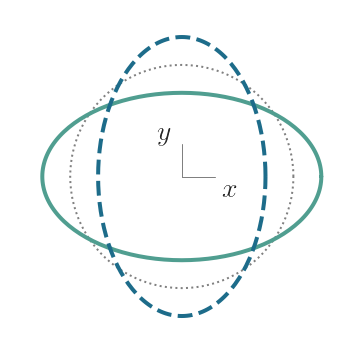

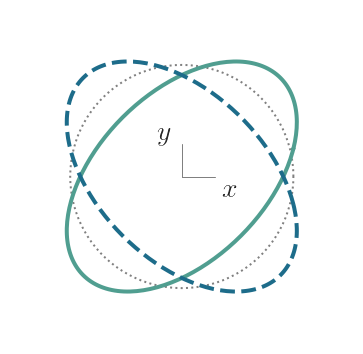

In [4]:
for k, th in zip(["plus", "cross"], [0, np.pi/2]):
    plot_circle(A=0.25, ellip=0, theta=th, Npoints=200);
    plt.savefig(f"pol_ring_{k}.pdf", bbox_inches="tight")

## Time evolution

Produce a plot illustrating the effect of a monochromatic, fully-polarized GW over time.

In [5]:
def plot_diagram(A=0.2, ellip=1, theta=0, A0=1, Nt=5, Npoints=16, ax_width=None,
                i0=4, palette='crest'):
    wts = np.linspace(0, 2*np.pi, Nt)

    th = np.linspace(0, 2*np.pi, Npoints, endpoint=False)
    X = A0*np.cos(th)
    Y = A0*np.sin(th)
    
    ax_width = ax_width or 2*A0

    nrow = 3
    fig = plt.figure(constrained_layout=True, figsize=(ax_width*Nt, nrow*ax_width))
    gs = fig.add_gridspec(nrow, Nt)
    
    ellip_kws = dict(ellip=ellip, theta=theta)

    # draw the trajectory of a highlighted point
    x, y = X[i0], Y[i0]
    dxs, dys = [], []
    for wt in np.linspace(0, 2*np.pi, 50):
        dx, dy = dxdy_ellip([x, y], wt, A=A, **ellip_kws)
        dxs.append(dx)
        dys.append(dy)
    dxs = np.array(dxs)
    dys = np.array(dys)

    # initial angle for highlighted point
    th0 = np.arctan2(dys[0], dxs[0])

    c = sns.color_palette(palette, n_colors=Npoints)
    for i, wt in enumerate(wts):
        ax = fig.add_subplot(gs[0, i])
        
        ax.axhline(0, 0.5, 0.6, c='gray', lw=0.5)
        ax.axvline(0, 0.5, 0.6, c='gray', lw=0.5)
        kws = dict(fontsize=14, horizontalalignment='right', verticalalignment='top')
        if i==0:
            ax.annotate(r'$x$', xy=(0.5, 0), **kws)
            ax.annotate(r'$y$', xy=(-0.1, 0.5), **kws)
        
        dX, dY = dxdy_ellip([X, Y], wt, A=A, **ellip_kws)

        # highlighted point
        wedge = EllipticalWedge([X[i0], Y[i0]], A*A0, 0, np.rad2deg(wt), ellip=ellip,
                                angle=th0, color=c[i0], alpha=0.15)
        ax.add_patch(wedge)
        ax.annotate("", xy=(X[i0] + dX[i0], Y[i0] + dY[i0]), xytext=(X[i0], Y[i0]),
                    arrowprops=dict(arrowstyle="-", color=c[i0], alpha=0.6))
        ax.plot(x+dxs, y+dys, c=c[i0], alpha=0.6, lw=1, ls=':')


        ax.scatter(X, Y, label=wt, edgecolors=c, facecolor='none', s=5, alpha=0.5)
        ax.scatter(X + dX, Y + dY, c=c)

        ax.axis('off')
        ax.axis('equal')
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)

    # get offset of first subplot center in display coordinates
    w = ax.transData.transform((-1.2, 0))[0]

    ax = fig.add_subplot(gs[1,:])

    # convert the offset to coordinates of the new axis in
    w_new = 0.85*ax.transData.inverted().transform((w,0))[0]

    wts2 = np.linspace(0, 2*np.pi, 100)
    ax.axhline(0, c='gray', ls=':')
    for wt in wts:
        ax.axvline(wt, 0, 1, c='gray', ls=':')

    hp2, hc2 = hphc_ellip(wts2, A=1, **ellip_kws)

    ax.plot(wts2, hp2, lw=2, c=c[-1], label=r'$+$')
    ax.plot(wts2, hc2, lw=2, c=c[-5], ls='--', label=r'$\times$')
    
    ax.legend(loc='lower right', edgecolor='w')

    ax.set_xlim(-w_new, 2*np.pi+w_new)
    ax.set_ylim(-1.2, 1.2)
    ax.axis('off');

    hp, hc = hphc_ellip(wts, A=1, **ellip_kws)

    for i, wt in enumerate(wts):
        ax = fig.add_subplot(gs[2, i])

        ax.axhline(0, 0.5, c='gray', lw=1)
        ax.axvline(0, 0.5, c='gray', lw=1)
        kws = dict(fontsize=14, horizontalalignment='right', verticalalignment='top')
        if i==0:
            ax.annotate(r'$h_+$', xy=(1.45, -0.1), **kws)
            ax.annotate(r'$h_\times$', xy=(-0.05, 1.5), **kws)
            
        ax.plot(hp2, hc2)

        wedge = EllipticalWedge([0, 0], 1, 0, np.rad2deg(wt), ellip=ellip,
                                angle=theta, color=c[i0], alpha=0.15)
        ax.add_patch(wedge)
        ax.annotate("", xy=(hp[i], hc[i]), xytext=(0, 0),
                    arrowprops=dict(arrowstyle="->", color=c[-1], lw=2, 
                                    shrinkA=0, shrinkB=0))

        ax.axis('off')
        ax.axis('equal')
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
    return fig

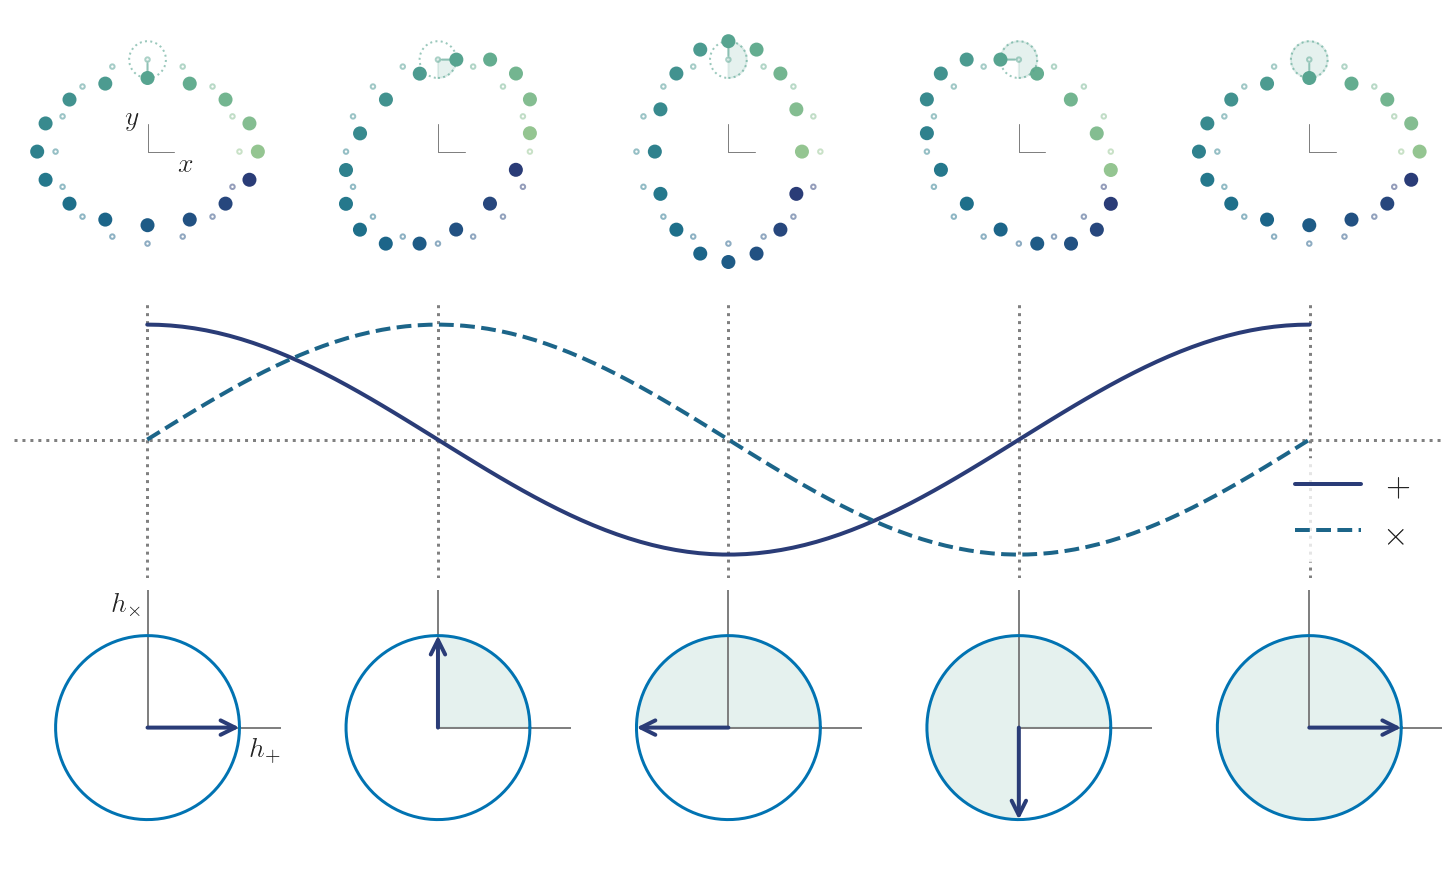

In [6]:
plot_diagram();
plt.savefig('pol_diagram_circ.pdf', bbox_inches='tight')

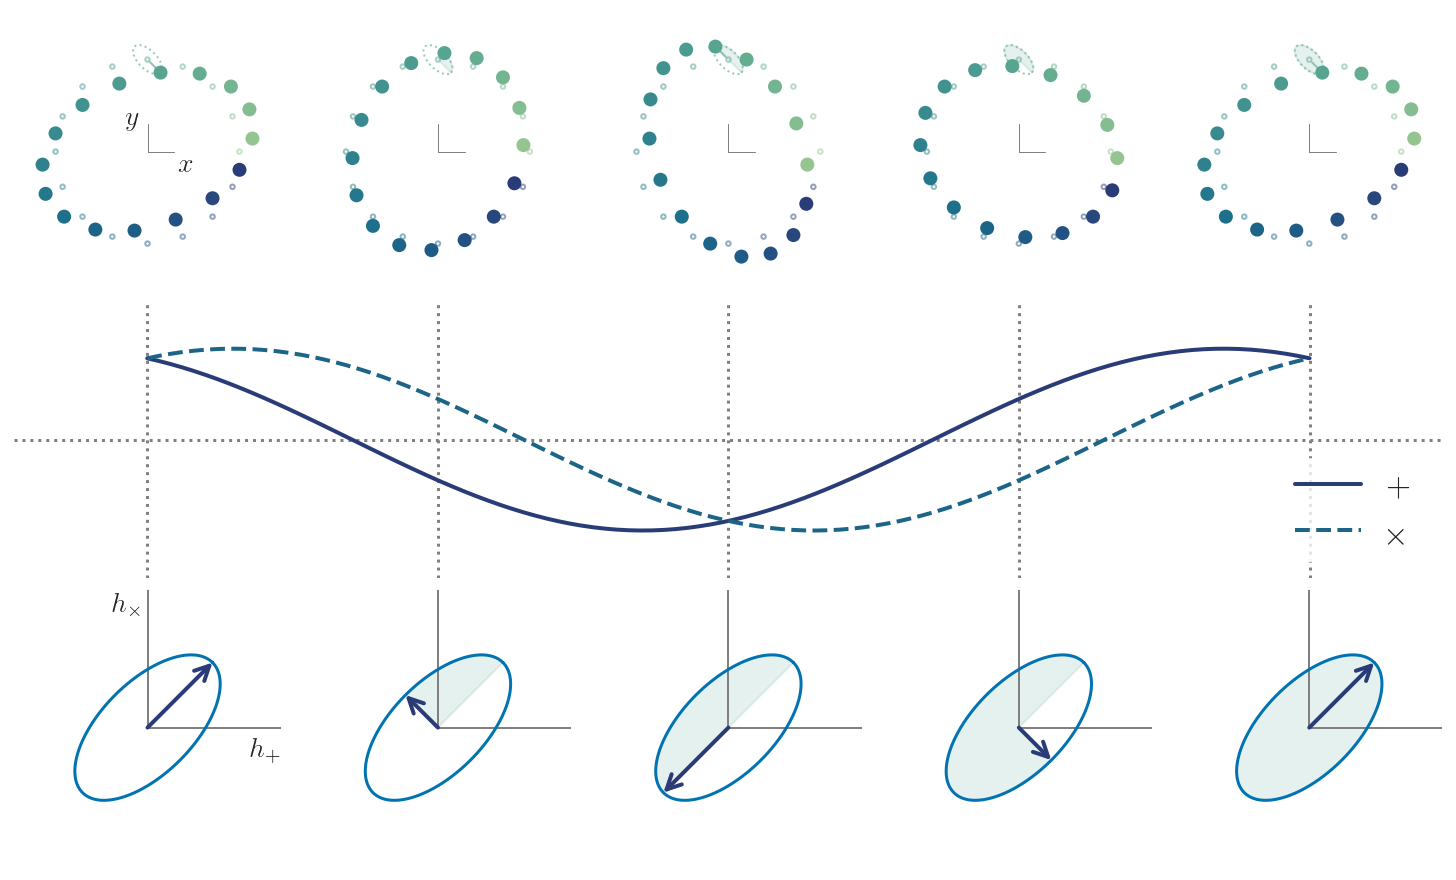

In [7]:
plot_diagram(A0=1, ellip=0.5, theta=np.pi/4);
plt.savefig('pol_diagram_ellip.pdf', bbox_inches='tight')

## License

Copyright 2022 Maximiliano Isi max.isi@ligo.org

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301, USA.